In [1]:
## Global Settings

In [2]:
#CLUSTER_ALGO = 'KMedoids'
CLUSTER_ALGO = 'KMeans'
N_CLUSTERS = [3]
CLUSTERS_STD = 1.0
N_P_CLUSTERS = [3,30, 100, 300, 3000]

In [3]:
%matplotlib inline

import matplotlib

import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons



In [4]:
%load_ext autoreload
%autoreload 2
packages = !conda list
packages

['# packages in environment at /opt/conda:',
 '#',
 '# Name                    Version                   Build  Channel',
 '_libgcc_mutex             0.1                 conda_forge    conda-forge',
 '_openmp_mutex             4.5                       0_gnu    conda-forge',
 'alembic                   1.4.2              pyh9f0ad1d_0    conda-forge',
 'astroid                   2.4.1                    pypi_0    pypi',
 'astunparse                1.6.3                    pypi_0    pypi',
 'async_generator           1.10                       py_0    conda-forge',
 'attrs                     19.3.0                     py_0    conda-forge',
 'backcall                  0.1.0                      py_0    conda-forge',
 'bleach                    3.1.4              pyh9f0ad1d_0    conda-forge',
 'blinker                   1.4                        py_1    conda-forge',
 'brotlipy                  0.7.0           py37h8f50634_1000    conda-forge',
 'ca-certificates           2020.4.5.1     

In [5]:
!pwd


/docker/photon_experiments/Cluster/kmeans-kmedoids


## Output registry

In [6]:
from __future__ import print_function
import sys, os

old__file__ = !pwd
__file__ = !cd ../../../photon ;pwd
#__file__ = !pwd
__file__ = __file__[0]
__file__
sys.path.append(__file__)
print(sys.path)
os.chdir(old__file__[0])
!pwd
old__file__[0]

['/docker/photon_experiments/Cluster/kmeans-kmedoids', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/home/jovyan/.ipython', '/docker/photon']
/docker/photon_experiments/Cluster/kmeans-kmedoids


'/docker/photon_experiments/Cluster/kmeans-kmedoids'

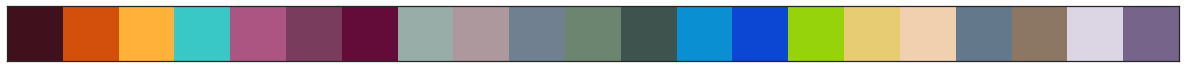

In [18]:
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#set style of plots
sns.set_style('white')

#define a custom palette  
customPalette = ['#40111D', '#D3500C', '#FFB139'
                 ,'#39C8C6', '#AC5583', '#7A3C5D'
                 ,'#630C3A', '#98ADA7', '#AD989E'  
                 ,'#708090','#6C8570','#3E534D'
                 ,'#0B8FD3','#0B47D3','#96D30B'                 
                 ,'#E7CC74','#F1D0AF','#64788B'                 
                 ,'#8B7764','#DCD5E4','#77648B',]
sns.set_palette(customPalette)
sns.palplot(customPalette)


from clusim.clustering import Clustering, remap2match
import clusim.sim as sim

from photonai.base import Hyperpipe, PipelineElement, Preprocessing, OutputSettings
from photonai.optimization import FloatRange, Categorical, IntegerRange
from photonai.base.photon_elements import PhotonRegistry
from photonai.visual.graphics import plot_cm
#from photonai.base.registry.registry import PhotonRegistry

In [8]:
#import pixiedust


In [9]:
def results_to_df(results):
    ll = []
    for obj in results:
        ll.append([obj.operation,
        obj.value,
        obj.metric_name])
    _results=pd.DataFrame(ll).pivot(index=2, columns=0, values=1)
    _results.columns=['Mean','STD']
    
    return(_results)

In [10]:
__file__ = "exp1.log"
base_folder = os.path.dirname(os.path.abspath(''))
custom_elements_folder = os.path.join(base_folder, 'custom_elements')
custom_elements_folder

'/docker/photon_experiments/Cluster/custom_elements'

In [11]:
registry = PhotonRegistry(custom_elements_folder=custom_elements_folder)
registry.activate()
registry.PHOTON_REGISTRIES,PhotonRegistry.PHOTON_REGISTRIES

(['PhotonCore', 'PhotonCluster', 'PhotonNeuro', 'CustomElements'],
 ['PhotonCore', 'PhotonCluster', 'PhotonNeuro', 'CustomElements'])

In [12]:
registry.activate()
registry.list_available_elements()
# take off last name


PhotonCore
ARDRegression                       sklearn.linear_model.ARDRegression                                          Estimator
AdaBoostClassifier                  sklearn.ensemble.AdaBoostClassifier                                         Estimator
AdaBoostRegressor                   sklearn.ensemble.AdaBoostRegressor                                          Estimator
BaggingClassifier                   sklearn.ensemble.BaggingClassifier                                          Estimator
BaggingRegressor                    sklearn.ensemble.BaggingRegressor                                           Estimator
BayesianGaussianMixture             sklearn.mixture.BayesianGaussianMixture                                     Estimator
BayesianRidge                       sklearn.linear_model.BayesianRidge                                          Estimator
BernoulliNB                         sklearn.naive_bayes.BernoulliNB                                             Estimator
BernoulliRBM

## KMeans blobs

In [13]:
registry.info("KMeans")

----------------------------------
Name: KMeans
Namespace: sklearn.cluster
----------------------------------
Possible Hyperparameters as derived from constructor:
n_clusters                          n_clusters=8                                                               
init                                init='k-means++'                                                           
n_init                              n_init=10                                                                  
max_iter                            max_iter=300                                                               
tol                                 tol=0.0001                                                                 
precompute_distances                precompute_distances='auto'                                                
verbose                             verbose=0                                                                  
random_state                        random_state=Non

('KMeans',
 'sklearn.cluster',
 {'n_clusters': 'n_clusters',
  'init': 'init',
  'n_init': 'n_init',
  'max_iter': 'max_iter',
  'tol': 'tol',
  'precompute_distances': 'precompute_distances',
  'verbose': 'verbose',
  'random_state': 'random_state',
  'copy_x': 'copy_x',
  'n_jobs': 'n_jobs',
  'algorithm': 'algorithm'})

In [14]:
import sklearn.datasets as skd
NC = N_CLUSTERS[0]
def yield_parameters(n_p_clusters):
    n_cluster = NC

    for n_p_cluster in n_p_clusters:
        n_cluster_std = CLUSTERS_STD #[cluster_std*k**0.5+0.2 for k in range(n_cluster)]
        print("n_cluster_std:", n_cluster_std)
        n_samples = [n_p_cluster for k in range(n_cluster)]
        data_X, data_y = make_blobs(n_samples=n_samples,
                                   cluster_std=n_cluster_std, random_state=0)
        yield [data_X, data_y]

In [15]:
#import pixiedust
#%%pixie_debugger

In [16]:
def hyper_cluster(cluster_name):
    
    n_p_clusters = [3,30, 100, 300, 3000]

    for data_X, data_y  in yield_parameters(n_p_clusters):
        print('n_points:', len(data_y))
        """
        Example script for KMedoids hopt
        """
        X = data_X.copy(); y =  data_y.copy()
        # DESIGN YOUR PIPELINE
        settings = OutputSettings(project_folder='./tmp/')

        my_pipe = Hyperpipe('batching',
                            optimizer='sk_opt',
        #                    optimizer_params={'n_configurations': 25},
                            metrics=['ARI', 'MI', 'HCV', 'FM'],
                            best_config_metric='ARI',
                            outer_cv=KFold(n_splits=int(N_CLUSTERS[0])),
                            inner_cv=KFold(n_splits=int(N_CLUSTERS[0])),
                            verbosity=0,
                            output_settings=settings)


        my_pipe += PipelineElement(cluster_name
                                   , hyperparameters={
                                       'n_clusters': IntegerRange(2, NC),
                                   },random_state=777)

        # NOW TRAIN YOUR PIPELINE
        my_pipe.fit(X, y)

        debug = True
    #------------------------------plot
        y_pred= my_pipe.predict(X)
        data = pd.DataFrame(data_X[:, 0],columns=['x'])
        data['y'] = data_X[:, 1]
        data['labels'] = y_pred
#        sns.set(rc={'figure.figsize':(10,10)})
        facet = sns.lmplot(data=data, x='x', y='y', hue='labels', 
                           aspect= 1.0, height=7,
                   fit_reg=False, legend=True, legend_out=True)
    
        for i, label in enumerate( np.sort(data['labels'].unique())):

        #add label
            plt.annotate(label, 
                         data.loc[data['labels']==label,['x','y']].mean(),
                         horizontalalignment='center',
                         verticalalignment='center',
                         size=10, weight='bold',
                         color='white',
                         backgroundcolor=customPalette[i]) 

        plt.show()
    #--------------------------------- best
        print(pd.DataFrame(my_pipe.best_config.items()
                           ,columns=['n_clusters', 'k']))
    #------------------------------
        print('train','\n'
              ,results_to_df(my_pipe.results.metrics_train))
        print('test','\n'
              ,results_to_df(my_pipe.results.metrics_test))
    #------------------------------   
        # turn the ground-truth labels into a clusim Clustering
        true_clustering = Clustering().from_membership_list(y) 
        kmeans_clustering = Clustering().from_membership_list(y_pred) # lets see how similar the predicted k-means clustering is to the true clustering
    #------------------------------
        # using all available similar measures!
        row_format2 ="{:>25}" * (2)
        for simfunc in sim.available_similarity_measures:
            print(row_format2.format(simfunc, eval('sim.' + simfunc+'(true_clustering, kmeans_clustering)')))
    #------------------------------# The element-centric similarity is particularly useful for understanding
    # how a clustering method performed

    # Let's start with the single similarity value:
        elsim = sim.element_sim(true_clustering, kmeans_clustering)
        print("Element-centric similarity: {}".format(elsim))

n_cluster_std: 1.0
n_points: 9
***************************************************************************************************************
PHOTON ANALYSIS: batching
***************************************************************************************************************

********************************************************
Outer Cross validation Fold 1
********************************************************
---------------------------------------------------------------------------------------------------------------
BEST_CONFIG 
---------------------------------------------------------------------------------------------------------------
{
    "KMeans": [
        "n_clusters=3"
    ]
}
+--------+-------------------+------------------+
| METRIC | PERFORMANCE TRAIN | PERFORMANCE TEST |
+--------+-------------------+------------------+
|  ARI   |       1.0000      |      1.0000      |
|   MI   |       1.0000      |      1.0000      |
|  HCV   |       1.0000      |      1.

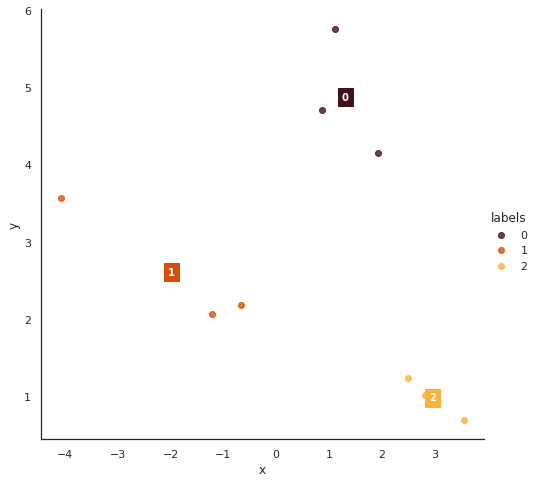

           n_clusters  k
0  KMeans__n_clusters  3
train 
      Mean  STD
2             
ARI   1.0  0.0
FM    1.0  0.0
HCV   1.0  0.0
MI    1.0  0.0
test 
      Mean  STD
2             
ARI   1.0  0.0
FM    0.0  0.0
HCV   1.0  0.0
MI    1.0  0.0
            jaccard_index                      1.0
               rand_index                      1.0
            adjrand_index                      1.0
    fowlkes_mallows_index                      1.0
                 fmeasure                      1.0
             purity_index                      1.0
     classification_error                      0.0
        czekanowski_index                      1.0
               dice_index                      1.0
           sorensen_index                      1.0
    rogers_tanimoto_index                      1.0
          southwood_index                      1.0
      pearson_correlation      0.00411522633744856
         corrected_chance                      1.0
      sample_expected_sim                

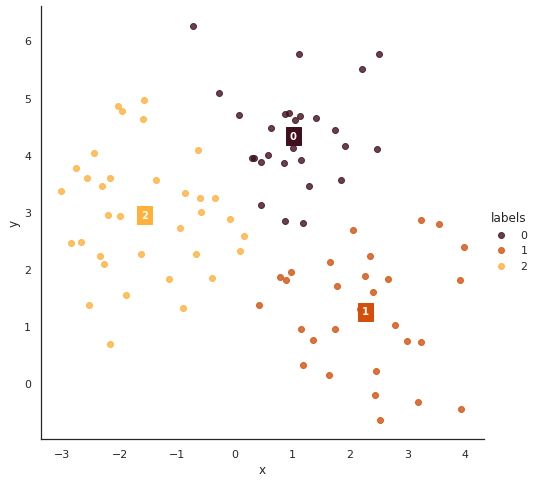

           n_clusters  k
0  KMeans__n_clusters  3
train 
          Mean       STD
2                      
ARI  0.723778  0.019190
FM   0.815926  0.011887
HCV  0.714613  0.023394
MI   0.704740  0.023557
test 
          Mean       STD
2                      
ARI  0.711271  0.032782
FM   0.812604  0.024348
HCV  0.756342  0.010777
MI   0.728558  0.009960
            jaccard_index       0.6900773195876289
               rand_index       0.8799001248439451
            adjrand_index       0.7273364203231786
    fowlkes_mallows_index        0.816632218065415
                 fmeasure       0.8166221883339687
             purity_index                      0.9
     classification_error      0.09999999999999998
        czekanowski_index       0.8166221883339687
               dice_index       0.8166221883339687
           sorensen_index       0.8166221883339687
    rogers_tanimoto_index       0.7855550601872492
          southwood_index        2.226611226611227
      pearson_correlation   2.05905

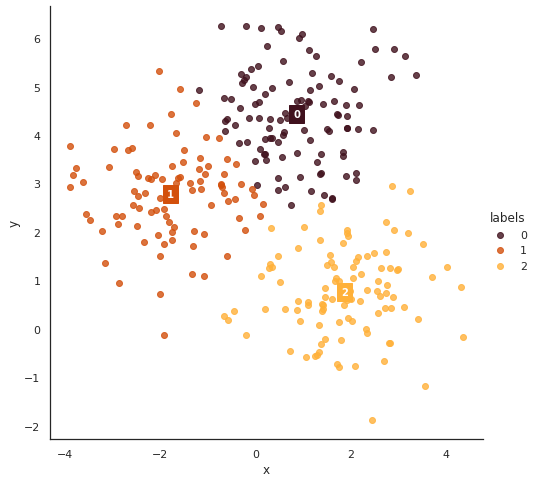

           n_clusters  k
0  KMeans__n_clusters  3
train 
          Mean       STD
2                      
ARI  0.748735  0.038419
FM   0.831972  0.025479
HCV  0.691256  0.032928
MI   0.689182  0.032682
test 
          Mean       STD
2                      
ARI  0.766890  0.095371
FM   0.843354  0.064268
HCV  0.717656  0.113528
MI   0.713156  0.116487
            jaccard_index       0.7302187572725157
               rand_index       0.8966109253065775
            adjrand_index       0.7667434002939801
    fowlkes_mallows_index       0.8440775273265899
                 fmeasure       0.8440768015064394
             purity_index       0.9166666666666667
     classification_error      0.08333333333333326
        czekanowski_index       0.8440768015064394
               dice_index       0.8440768015064394
           sorensen_index       0.8440768015064394
    rogers_tanimoto_index       0.8125972477620386
          southwood_index        2.706706922579254
      pearson_correlation   1.71995

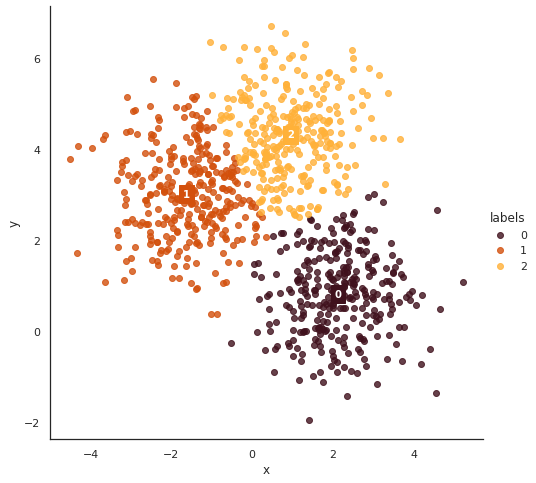

           n_clusters  k
0  KMeans__n_clusters  3
train 
          Mean       STD
2                      
ARI  0.801580  0.008527
FM   0.867542  0.005688
HCV  0.750335  0.008431
MI   0.749603  0.008484
test 
          Mean       STD
2                      
ARI  0.803889  0.022847
FM   0.868955  0.015341
HCV  0.754675  0.023347
MI   0.753156  0.023560
            jaccard_index       0.7664588528678304
               rand_index       0.9120331232233345
            adjrand_index       0.8018805913400624
    fowlkes_mallows_index       0.8677913779990069
                 fmeasure       0.8677913460859744
             purity_index       0.9288888888888889
     classification_error      0.07111111111111112
        czekanowski_index       0.8677913460859744
               dice_index       0.8677913460859744
           sorensen_index       0.8677913460859744
    rogers_tanimoto_index       0.8382912593124413
          southwood_index        3.281900694073679
      pearson_correlation   2.20700

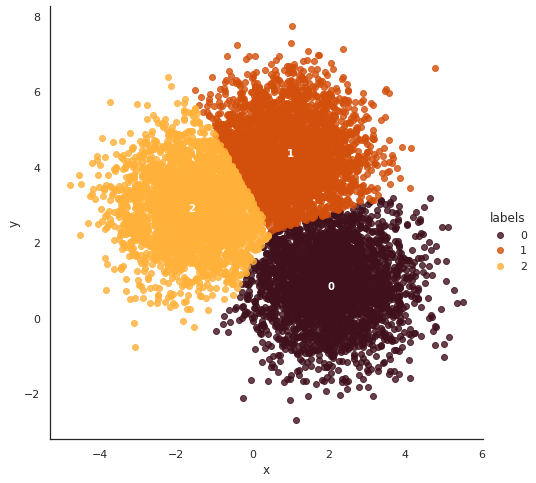

           n_clusters  k
0  KMeans__n_clusters  3
train 
          Mean       STD
2                      
ARI  0.788779  0.005939
FM   0.859188  0.003945
HCV  0.723415  0.005571
MI   0.723362  0.005549
test 
          Mean       STD
2                      
ARI  0.788120  0.013117
FM   0.858773  0.008786
HCV  0.723290  0.012330
MI   0.723133  0.012302
            jaccard_index       0.7523509427078025
               rand_index       0.9058035831141732
            adjrand_index       0.7880361089337654
    fowlkes_mallows_index       0.8586761070035599
                 fmeasure       0.8586761069049785
             purity_index       0.9241111111111111
     classification_error       0.0758888888888889
        czekanowski_index       0.8586761069049785
               dice_index       0.8586761069049785
           sorensen_index       0.8586761069049785
    rogers_tanimoto_index       0.8278253969174609
          southwood_index       3.0379721648611584
      pearson_correlation   2.16266

In [ ]:
hyper_cluster('KMeans')